# Visualization of synaptic effects and calculation of time and length constants 

## IMPORTS

In [1]:
try:
        
    import h5py
    
    from ipywidgets import widgets, Layout, interact, interactive, interactive_output, Dropdown
    from IPython.display import display
    import matplotlib.pyplot as mplt
    import numpy as np
    import random
    import math
    import seaborn as sns 
    import pandas as pd
    import graphing as gr
    #!pip install viola
    ########## Modules required for artist drawing on matplotlib
    import matplotlib.path as mpath
    import matplotlib.lines as mlines
    import matplotlib.patches as mpatches
    from matplotlib.collections import PatchCollection
    
      
except ModuleNotFoundError:
        print("A class you are trying to import is not present in the directory")
    
except Exception:
        print("Something went wrong - modules have not been imported")

else: 
    print("All relevant classes imported")

All relevant classes imported


## FILE SELECTION

In [2]:
#######################################################
#### GUI 

edt_filename = widgets.Text(description = 'File name', value=' Test-inhib3')
btn_select = widgets.Button(description = 'Select file',button_style='success')
output_file = widgets.Output()

display(edt_filename, btn_select,output_file)



#######################################################
#### FUNCTIONS


#df_flux = pd.DataFrame({'Compartment':[],'Na_net':[], 'Na_leak':[],'Na_Atpase':[], 'K_net':[],'K_leak':[],'K_Atpase':[],'K_kcc2':[], 'Cl_net':[],'Cl_kcc2':[],'X':[],'z':[]  })
df_ed = pd.DataFrame({'Boundary':[],'Na':[],'K':[],'Cl':[]})



def btn_select_clicked(b):
    global file_name, df_end, df_start, df_end_flux, df_end_ed, df_end_net_flux
    file_name = "\\"
    file_name = file_name + edt_filename.value 
    
    try: 
        with h5py.File(file_name, mode='r') as hdf:
            
            print("File found and content loaded into memory")
            global C, comp_names_arr, intervals, interval_arr, master_arr, t_arr, ED_master_arr,E_group_arr
            C = hdf.get('COMPARTMENTS')
            C_group_arr =[]
            t_arr_bool = True
            comp_names_arr= list(C.keys())
                        
            C1 = C.get(comp_names_arr[0])
            
            T = hdf.get('TIMING')
            total_t = T.get('TOTAL_T')[()]
            intervals = T.get('INTERVALS')[()]
            dt = T.get("DT")[()]
            total_steps = total_t /dt          
            interval_step = total_steps / intervals
            interval_arr = [round(interval_step * i) for i in range(intervals)]
            
            master_arr = []
            t_arr =[]
            
           
            
            
            
            ##### LOADING COMPARTMENT DATA
            for e in range(len(comp_names_arr)):
                C_group = C.get(comp_names_arr[e])
                C_group_arr.append(C_group)
               
                data_arr_2 =[]
                for j in range(len(list(C_group.keys()))):
                    dataset = C_group.get(str(interval_arr[j]))
                    
                    data_arr = []
                    for d in range(len(list(dataset))):
                        data_arr.append(dataset[d])
                    
                    data_arr_2.append(data_arr)
            
                    if t_arr_bool == True:
                        t_arr.append(data_arr[0])         
                
                master_arr.append(data_arr_2)
                t_arr_bool = False
                
            
            #df_start['radius'] = 
            
            E = hdf.get('ELECTRODIFFUSION')
            E_group_arr = list(E.keys())
            ED_master_arr = []            
            
            ##### LOADING ELECTRODIFFUSION DATA
            for x in range(len(E_group_arr)): # Looping through the electrodiffusion groups on the file
                
                E_group = E.get(E_group_arr[x])
                
                ED_data_arr =[] #stores the electrodiffusion data for a group
                
                for y in range(len(list(E_group.keys()))-1): # Looping through all the datasets of the group
                    
                    dataset = E_group.get(str(interval_arr[y+1]))
                   
                    ED_data_arr_2 = [] #stores the dataset values for one dataset
                    for z in range(len(list(dataset))): # Looping through the individual datasets to extract data
                        ED_data_arr_2.append(dataset[z])
                    
                    
                    ED_data_arr.append(ED_data_arr_2) 
                    
            
                ED_master_arr.append(ED_data_arr) #contains all the electrodiffusion data for all the groups (1st index is the group, 2nd index is the interval)
            
            
            ###### SYNAPSE DATA ######
            S = hdf.get('SYNAPSE-SETTINGS')
            s_arr = list(S.keys())
            for s in range(len(s_arr)):
                s_data_arr = []
                s_dataset = S.get(s_arr[s])[()]
                for d in range(len(s_dataset)):
                    s_data_arr.append(s_dataset[d])
            
            global df_synapses
            df_synapses = pd.DataFrame(data=s_data_arr, index=['Compartment Name','Synapse Type','Start time(s)','Duration(s)','End time(s)','Max NT(mM)','Synaptic conductance'])
            
            
        ################
        # DATAFRAMES
        ################
    
        # START VALUE DATAFRAME
        df_start_data = [master_arr[i][0][1:9] for i in range(len(comp_names_arr))]
        df_start=pd.DataFrame(data=df_start_data, index=comp_names_arr)
        df_start.columns = ['Radius', 'Length', 'Volume', 'Na_i', 'K_i', 'Cl_i','X_i','z_i']
        
        # END VALUE DATAFRAME
        df_end_data = [master_arr[i][-1][1:9] for i in range(len(comp_names_arr))]
        for i in range(len(comp_names_arr)):
            df_end_data[i].append(master_arr[i][-1][-3]*1e3) #vm
            df_end_data[i].append(master_arr[i][-1][-2]*1e3) #ek
            df_end_data[i].append(master_arr[i][-1][-1]*1e3) #ecl
            df_end_data[i].append((master_arr[i][-1][-3]-master_arr[i][-1][-1])*1e3) #driving force
            
        df_end=pd.DataFrame(data=df_end_data,index=comp_names_arr)
        df_end.columns = ['Radius', 'Length', 'Volume', 'Na_i', 'K_i', 'Cl_i','X_i','z_i','Vm (mV)','Ek (mV)','ECl (mV)','Cl-Driving force (mV)']
        
        
        # END TRANSMEMBRANE FLUX DATAFRAME
        
        final_mol_data =  [master_arr[i][-1][9:19]  for i in range(len(comp_names_arr))]
        #semifinal_mol_data =  [master_arr[i][-2][9:19]  for i in range(len(comp_names_arr))]
        
        df_end_flux_data = []
        
    
        for i in range(len(final_mol_data)):
            temp_arr =[]
            for j in range(len(final_mol_data[i])):
                final_mol_data[i][j] = final_mol_data[i][j] * master_arr[i][-1][3]
                #semifinal_mol_data[i][j] = semifinal_mol_data[i][j] * master_arr[i][-2][3]
                #temp_arr.append(final_mol_data[i][j]-semifinal_mol_data[i][j])
            #df_end_flux_data.append(temp_arr)
            
            
        df_end_flux_cols = ['Na_net', 'Na_leak','Na_Atpase', 'K_net','K_leak','K_Atpase','K_kcc2', 'Cl_net','Cl_leak','Cl_kcc2']
        df_end_flux = pd.DataFrame(data =final_mol_data, index = comp_names_arr, columns=df_end_flux_cols)
        
        # END ELECTRODIFFUSION DATAFRAME
        df_end_ed_data = [ED_master_arr[i][-1][0:3] for i in range(len(ED_master_arr))]
        for i in range(len(df_end_ed_data)):
            for j in range(3):
                df_end_ed_data[i][j] = df_end_ed_data[i][j] * master_arr[i][-1][3]
                    
        
        df_end_ed_cols = ['Na_ED_flux', 'K_ED_flux', 'Cl_ED_flux']
        df_end_ed = pd.DataFrame(data = df_end_ed_data, index = E_group_arr, columns=df_end_ed_cols)
        
        
        
        # NET FLUX DATAFRAME
        na_net_arr, k_net_arr,cl_net_arr,x_net_arr,total_net_arr = [],[],[],[],[]
       
        for i in range(len(comp_names_arr)):
            na_net_arr.append(df_end_flux.iloc[i][0])
            k_net_arr.append(df_end_flux.iloc[i][3])
            cl_net_arr.append(df_end_flux.iloc[i][7])

        x_net_arr = [((master_arr[i][-1][7] * master_arr[i][-1][3]) -(master_arr[i][-2][7] * master_arr[i][-2][3]))  for i in range(len(comp_names_arr))]
        #(master_arr[i][-2][7]- master_arr[i][-2][3]
        
        for j in range(len(E_group_arr)):
            na_net_arr[j] = na_net_arr[j] - df_end_ed.iloc[j][0]
            na_net_arr[j+1] = na_net_arr[j+1] + df_end_ed.iloc[j][0]
            k_net_arr[j] = k_net_arr[j] - df_end_ed.iloc[j][1]
            k_net_arr[j+1] = k_net_arr[j+1] + df_end_ed.iloc[j][1]
            cl_net_arr[j] = cl_net_arr[j] + df_end_ed.iloc[j][2]
            cl_net_arr[j+1] = cl_net_arr[j+1] - df_end_ed.iloc[j][2]

        total_net_arr = [na_net_arr[a]+k_net_arr[a]-cl_net_arr[a]-x_net_arr[a] for a in range(len(comp_names_arr))]


        df_end_net_flux = pd.DataFrame(data ={'Na-Net':na_net_arr, 'K-Net':k_net_arr,'Cl-Net':cl_net_arr,'X-Net':x_net_arr,'Total':total_net_arr }, index=comp_names_arr)     


            
    except: 
        raise("File not found")
        raise("File needs to be in base directory")


btn_select.on_click(btn_select_clicked)

Text(value=' Test-inhib3', description='File name')

Button(button_style='success', description='Select file', style=ButtonStyle())

Output()

File found and content loaded into memory


In [3]:
df_synapses

,0
Compartment Name,8.000000e+00
Synapse Type,0.000000e+00
Start time(s),5.000000e-02
Duration(s),2.000000e-03
End time(s),5.200000e-02
Max NT(mM),1.000000e-03
Synaptic conductance,1.200000e-09


## Comparing synapse compartment to soma

Button(button_style='success', description='Plot', style=ButtonStyle())

Output()

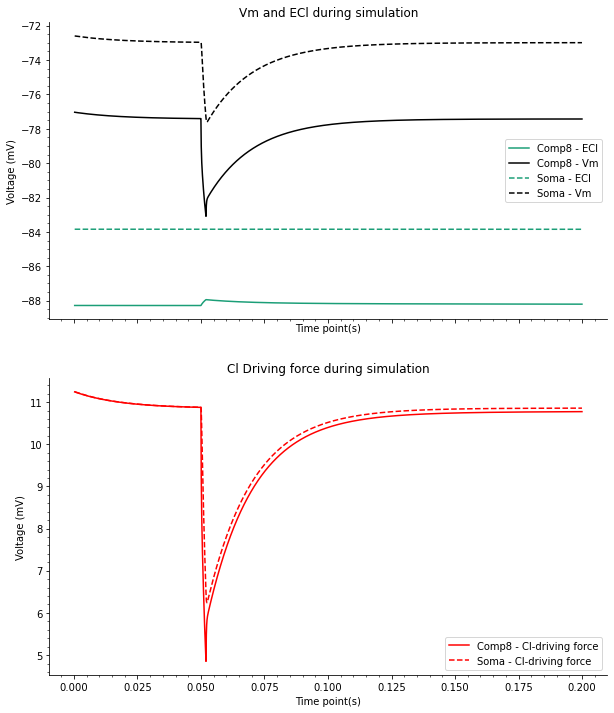

In [6]:
#############################
# GUI

btn_synapse = widgets.Button(description ="Plot", button_style = 'success' )
output_synapse = widgets.Output()

display(btn_synapse,output_synapse)
#############################

def btn_synapse_clicked(b):
    
    f_synapse, (ax_synapse, ax_driving_force) = mplt.subplots(2,1, figsize=(10,12), sharex=True)
    synapse_comp_name = "Comp8"
    soma_name = "0_Soma"
    comp_ecl_arr, comp_vm_arr, soma_ecl_arr, soma_vm_arr = [],[],[],[]
    comp_df_arr, soma_df_arr = [],[]
    
    for i in range(len(comp_names_arr)):
        if comp_names_arr[i] == synapse_comp_name:
            synapse_comp_num = i
        elif comp_names_arr[i] == soma_name:
            soma_comp_num = i
    

    for i in range(len(master_arr[0])):
        comp_ecl_arr.append(master_arr[synapse_comp_num][i][-1]*1e3)
        comp_vm_arr.append(master_arr[synapse_comp_num][i][-3]*1e3)
        comp_df_arr.append(master_arr[synapse_comp_num][i][-3]*1e3 - master_arr[synapse_comp_num][i][-1]*1e3)
        soma_ecl_arr.append(master_arr[soma_comp_num][i][-1]*1e3)
        soma_vm_arr.append(master_arr[soma_comp_num][i][-3]*1e3)
        soma_df_arr.append(master_arr[soma_comp_num][i][-3]*1e3 - master_arr[soma_comp_num][i][-1]*1e3)
        

    ax_synapse.plot(t_arr[5:],comp_ecl_arr[5:], color = '#1b9e77', label = 'Comp8 - ECl' )
    ax_synapse.plot(t_arr[5:],comp_vm_arr[5:], color = '#000000', label = 'Comp8 - Vm' )
    ax_synapse.plot(t_arr[5:],soma_ecl_arr[5:], color = '#1b9e77', linestyle = '--', label = 'Soma - ECl')
    ax_synapse.plot(t_arr[5:],soma_vm_arr[5:], color = '#000000', linestyle= '--',  label = 'Soma - Vm')
    ax_synapse.set_xlabel('Time point(s)')
    ax_synapse.set_ylabel('Voltage (mV)')
    ax_synapse.minorticks_on()
    ax_synapse.set_title("Vm and ECl during simulation")
    ax_synapse.legend()
    sns.despine()
    
    ax_driving_force.plot(t_arr[5:],comp_df_arr[5:], color = 'red', label = 'Comp8 - Cl-driving force' )
    ax_driving_force.plot(t_arr[5:],soma_df_arr[5:], color = 'red', label = 'Soma - Cl-driving force', linestyle = '--' )
    
    ax_driving_force.set_xlabel('Time point(s)')
    ax_driving_force.minorticks_on()
    ax_driving_force.set_ylabel('Voltage (mV)')
    ax_driving_force.set_title("Cl Driving force during simulation")
    ax_driving_force.legend()
    sns.despine()
    
    

#############################
btn_synapse.on_click(btn_synapse_clicked)

## Time constant

Min voltage = -83.0899001 mV @ 0.05200000000003135 s
Max voltage = -77.4296463 mV @ 0.19933300000017867 s
Voltage difference = 5.6602538 mV
Theoretical voltage of time constant = -79.5239402 mV 
Actual voltage of time constant = -79.526601 mV, difference being -0.0026608 mV
Time at actual time constant voltage = 0.06680000000004614 s 
Time constant = 14.800000000014794 ms


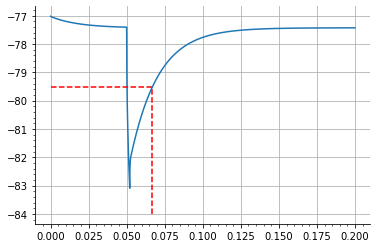

In [5]:
###########
global interval_min_voltage,min_voltage
min_voltage  = 0
interval_min_voltage = 0
t_max_voltage = 0
max_voltage  = -10000
t_min_voltage = 0 
v_difference = 0
t_difference = 0


for i in range(len(master_arr[8])):
    
    if master_arr[8][i][-3] < round(min_voltage,7):
        min_voltage = master_arr[8][i][-3]
        t_min_voltage = t_arr[i]
        interval_min_voltage = i
    elif master_arr[8][i][-3] > round(max_voltage,7):
        max_voltage = master_arr[8][i][-3]
        t_max_voltage = t_arr[i]
 
v_difference = max_voltage-min_voltage
v_time_constant_theoretical = min_voltage+(0.63*v_difference)


min_v_diff = 1000

for j in range(len(master_arr[8])):

    temp_v_diff = abs(v_time_constant_theoretical) - abs(master_arr[8][j][-3])  
    
    if abs(temp_v_diff) < abs(min_v_diff):
        min_v_diff = temp_v_diff
        v_time_constant_actual = master_arr[8][j][-3] 
        t_time_constant = t_arr[j]
        



print(f'Min voltage = {round(min_voltage*1e3,7)} mV @ {t_min_voltage} s')
print(f'Max voltage = {round (max_voltage*1e3,7)} mV @ {t_max_voltage} s')
print(f'Voltage difference = {round(v_difference*1e3,7)} mV')
print(f'Theoretical voltage of time constant = {round(v_time_constant_theoretical*1e3,7)} mV ')
print(f'Actual voltage of time constant = {round(v_time_constant_actual*1e3,7)} mV, difference being {round(min_v_diff*1e3,7)} mV')
print(f'Time at actual time constant voltage = {t_time_constant} s ')
print(f'Time constant = {(t_time_constant - t_min_voltage)*1e3} ms' )

f_tau,ax =mplt.subplots()
ax.plot(t_arr, [master_arr[8][i][-3]*1e3 for i in range(len(t_arr))])
ax.plot([t_time_constant,t_time_constant],[-84,v_time_constant_actual*1e3],color='r',linestyle='--')
ax.plot([0,t_time_constant],[v_time_constant_actual*1e3,v_time_constant_actual*1e3],color='r',linestyle='--')
ax.minorticks_on()
ax.grid()
sns.despine()

## Space constant

Total multicompartment length = 0.00105 dm
Voltage at Soma = -77.3579275 mV
Voltage at Compartment 8 = -83.0899001 mV
Voltage at Lambda = -79.47875736095168 mV
Length constant Lambda = 0.0004594372528062466 dm


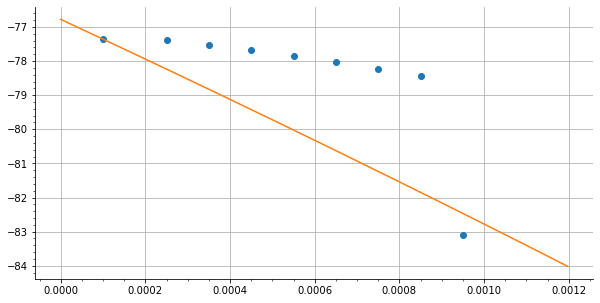

In [7]:
###########
voltage_arr = []
current_length = 0
length_arr = []
for i in range(len(comp_names_arr)):
    voltage_arr.append(master_arr[i][interval_min_voltage][-3])
    if i == 1:
        current_length += 15e-5
    else:
        current_length += 10e-5
    length_arr.append(current_length)


voltage_diff = abs(voltage_arr[8]) - abs(voltage_arr[0])  
lambda_voltage = voltage_arr[8] + (voltage_diff*0.63)
lambda_length = math.log((lambda_voltage*1e3)/(-76.7780459),4.77682*1e32)    
    
print(f'Total multicompartment length = {round(current_length,7)} dm')
print(f'Voltage at Soma = {round(voltage_arr[0]*1e3,7)} mV')
print(f'Voltage at Compartment 8 = {round(voltage_arr[8]*1e3,7)} mV')
print(f'Voltage at Lambda = {lambda_voltage*1e3} mV')
print(f'Length constant Lambda = {lambda_length} dm')

voltage_arr= [voltage_arr[i]*1e3 for i in range(len(voltage_arr))]

best_fit_x = [0.000001*i for i in range(1200)] 
best_fit_y = [-76.7780459*((4.77682*1e32)**i) for i in best_fit_x]



f_lambda, ax_lambda = mplt.subplots(figsize=(10,5))
ax_lambda.plot(length_arr[:-1:],voltage_arr[:-1:],'o')
ax_lambda.plot(best_fit_x[:-1:],best_fit_y[:-1:])
ax_lambda.minorticks_on()
ax_lambda.grid()
sns.despine()